In [1]:
import spectral as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import sys

sys.path.append('../')
from preprocessing import *
from plotting_parameters import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, Bbox
from mpl_toolkits.axes_grid1 import make_axes_locatable
# matplotlib.use("wxAgg")
%matplotlib inline
set_plotting_style("latex")
set_plotting_style("default")

Load image

c:\Users\User\anaconda3\envs\thesis\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

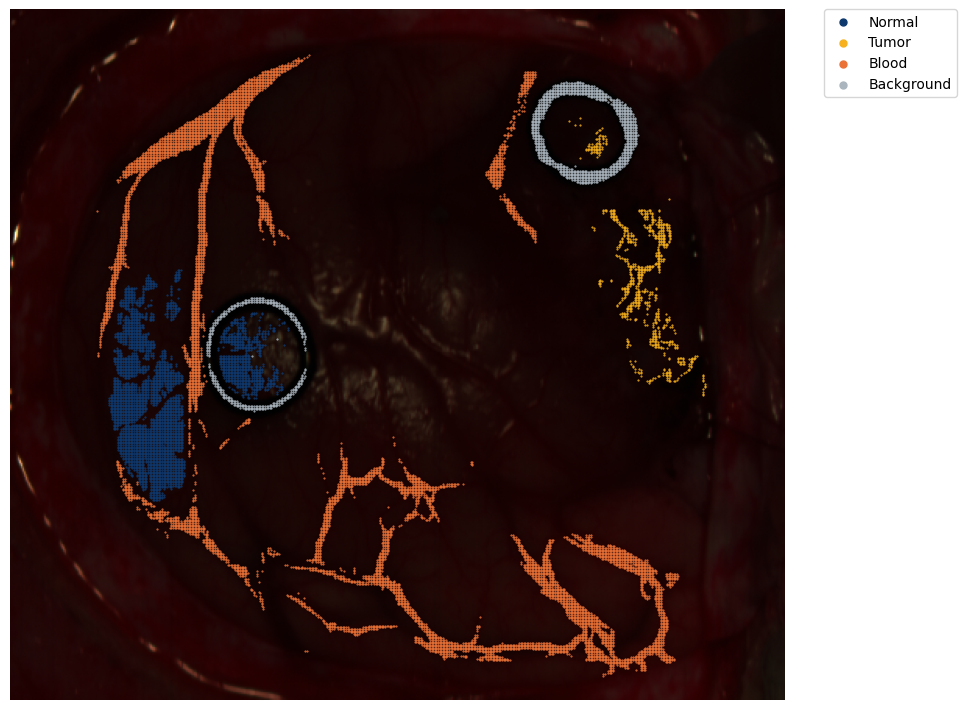

In [2]:
data_folder = "../datasets/helicoid/012-01"
class_labels = ["Not labled", "Normal", "Tumor", "Blood", "Background"]
class_colors = ["white", tum_blue_dark_2, tum_orange, tum_red, tum_grey_5]

# Load the sp data
img = sp.open_image(data_folder + "/raw.hdr")
white_ref = sp.open_image(data_folder + "/whiteReference.hdr")
dark_ref = sp.open_image(data_folder + "/darkReference.hdr")
gt_map = sp.open_image(data_folder + "/gtMap.hdr")

# Estimation of reflectance and emission
R = np.subtract(img.asarray(), dark_ref.asarray(), dtype=np.float32)
E = np.subtract(white_ref.asarray(), dark_ref.asarray(), dtype=np.float32).squeeze()

# plot the image
plot_img(img, gt_map, class_labels, class_colors, figsize=(10,10), legend=True)

### Subspace Projection tests

Analize noise of projected spectra


Text(0.5, 0.98, 'White Reference')

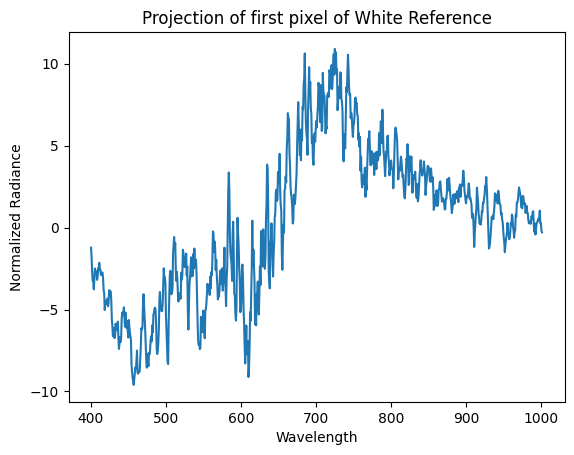

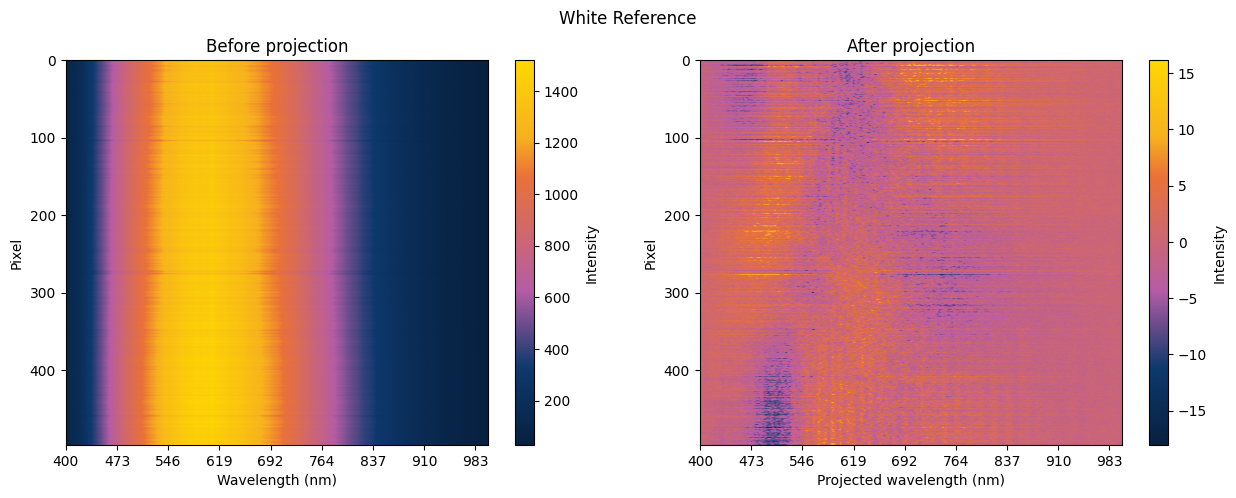

In [3]:
band_centers = img.bands.centers

# E, band_centers = band_removal(E, [450,900], orig_bands=img.bands.centers)

# smooth and average estimated emission to minimize noise
E = smooth_spectral(E, 5)
E_mean = np.mean(E, axis=0, dtype=np.float32)

# get mapping to subspace orthogonal to E
P_E = np.eye(E_mean.shape[0]) - np.outer(E_mean, E_mean)/np.dot(E_mean, E_mean)

# project white reference onto subspace orthogonal to E
E_proj = np.einsum('ij,kj->ki', P_E, E)

# plt.figure()
# plt.imshow(P_E, cmap='viridis', aspect='equal')
# cb = plt.colorbar()
# plt.title('Projection Matrix')

plt.figure()
plt.plot(band_centers, P_E @ E[0,:])
plt.title('Projection of first pixel of White Reference')
plt.xlabel('Wavelength')
plt.ylabel('Normalized Radiance')

# Plot white reference as image
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
im0 = axs[0].imshow(E, cmap=tum_cmap, aspect='auto')  # 'viridis' is just an example colormap; you can choose others
cb0 = plt.colorbar(im0)
cb0.set_label('Intensity')
axs[0].set_xticks(np.arange(0,E.shape[1],100))  # Set ticks to pixel numbers
axs[0].set_xticklabels([f'{wavelength:.0f}' for wavelength in band_centers[::100]])
axs[0].set_xlabel('Wavelength (nm)')
axs[0].set_ylabel('Pixel')
axs[0].set_title('Before projection')

im1 = axs[1].imshow(E_proj, cmap=tum_cmap, aspect='auto')
cb1 = plt.colorbar(im1, ax=axs[1])
cb1.set_label('Intensity')
axs[1].set_xticks(np.arange(0,E_proj.shape[1],100))  # Set ticks to pixel numbers
axs[1].set_xticklabels([f'{wavelength:.0f}' for wavelength in band_centers[::100]])
axs[1].set_xlabel('Projected wavelength (nm)')
axs[1].set_ylabel('Pixel')
axs[1].set_title('After projection')
fig.suptitle('White Reference')

Visualize spectrum component parallel to emission spectrum


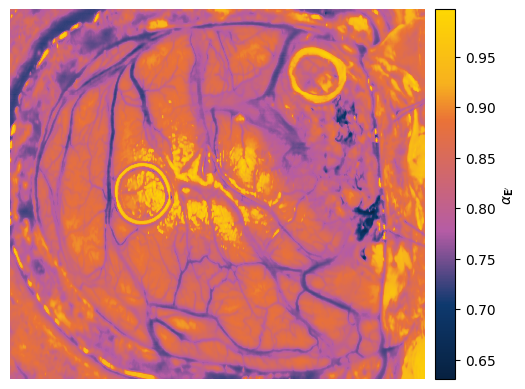

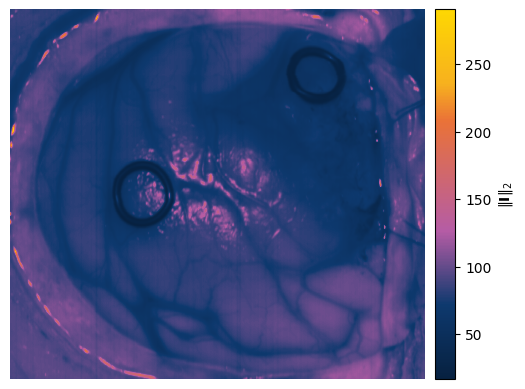

In [4]:
alpha_E = np.einsum('ijk,k->ij', R, E_mean) / (np.linalg.norm(E_mean) * np.linalg.norm(R, axis=2))

# magnitude in the direction of E
fig, ax = plt.subplots()
image = ax.imshow(alpha_E, cmap=tum_cmap, aspect='equal')
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(image, cax=cax, label=r"$\alpha_{\mathbf{E}'}$")
# save figure as svg
# plt.savefig("../figures/magnitude_of_E_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# total magnitude
img_norm = np.sqrt(np.linalg.norm(R, axis=2, ord=2))
fig, ax = plt.subplots()
image = ax.imshow(img_norm, cmap=tum_cmap, aspect='equal')
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(image, cax=cax, label=r"$\|\mathbf{I}\|_2$")

# comment: almost all of the light reflected from the rings is specular, which makes sense since they are black, so they have very little diffuse reflection
# also there are scanning lines in the image due to lighting changes?

### Comparison plots before and after preprocessing

load projected image and perform normalizations for later plots

In [14]:
# raw image
img_raw = img.asarray()

# calibrated image
img_calib = calibrate_img(img, white_ref, dark_ref)
img_calib_norm = img_calib/np.linalg.norm(img_calib, axis=-1, ord=1, keepdims=True)

# projected image
R_E = np.load(f"{data_folder}/results/R_E.npy")
R_E_norm = R_E/np.linalg.norm(R_E, axis=2, ord=1, keepdims=True)

# get band centers
band_centers = img.bands.centers


# img_raw, _ = band_removal(img_raw, [450.0, 900.0], img.bands.centers)
# img_calib, band_centers = band_removal(img_calib, [450.0, 900.0], img.bands.centers)
# img_calib_norm, _ = band_removal(img_calib_norm, [450.0, 900.0], img.bands.centers)
# R_E, _= band_removal(R_E, [450.0, 900.0], img.bands.centers)
# R_E_norm, _ = band_removal(R_E_norm, [450.0, 900.0], img.bands.centers)
# img_raw = smooth_spectral(img_raw, 5)

Plot examplary spectra from image before and after preprocessing

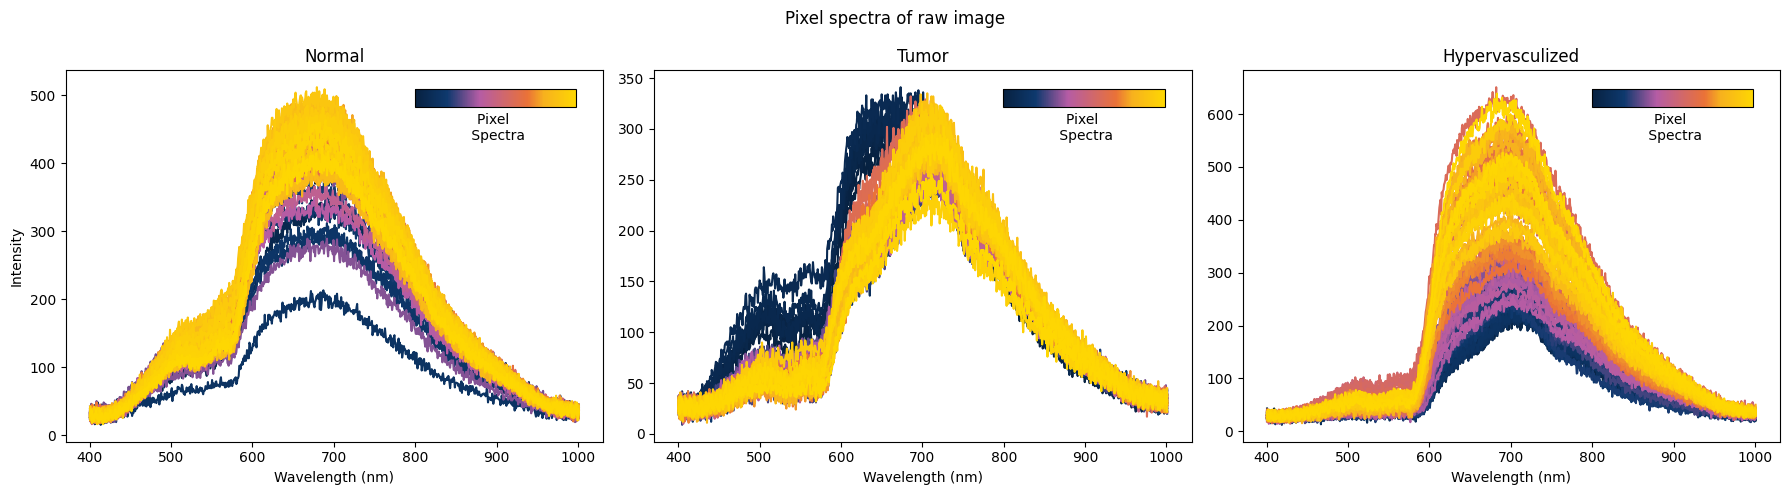

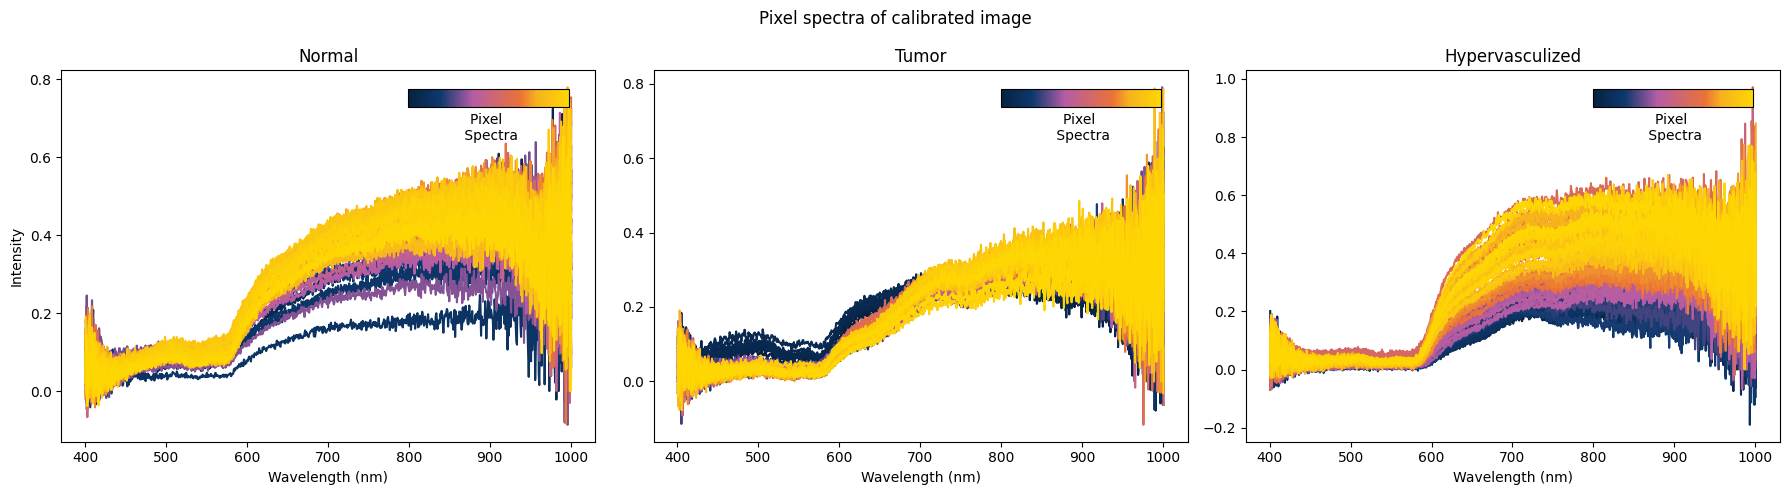

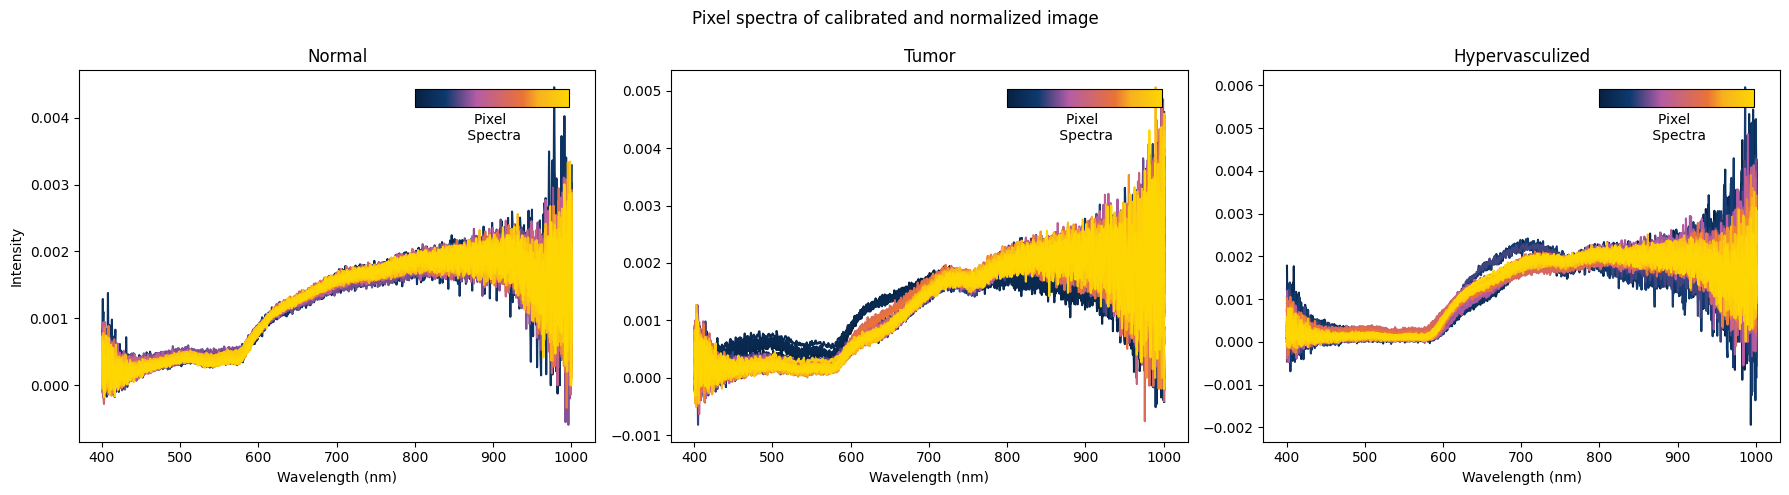

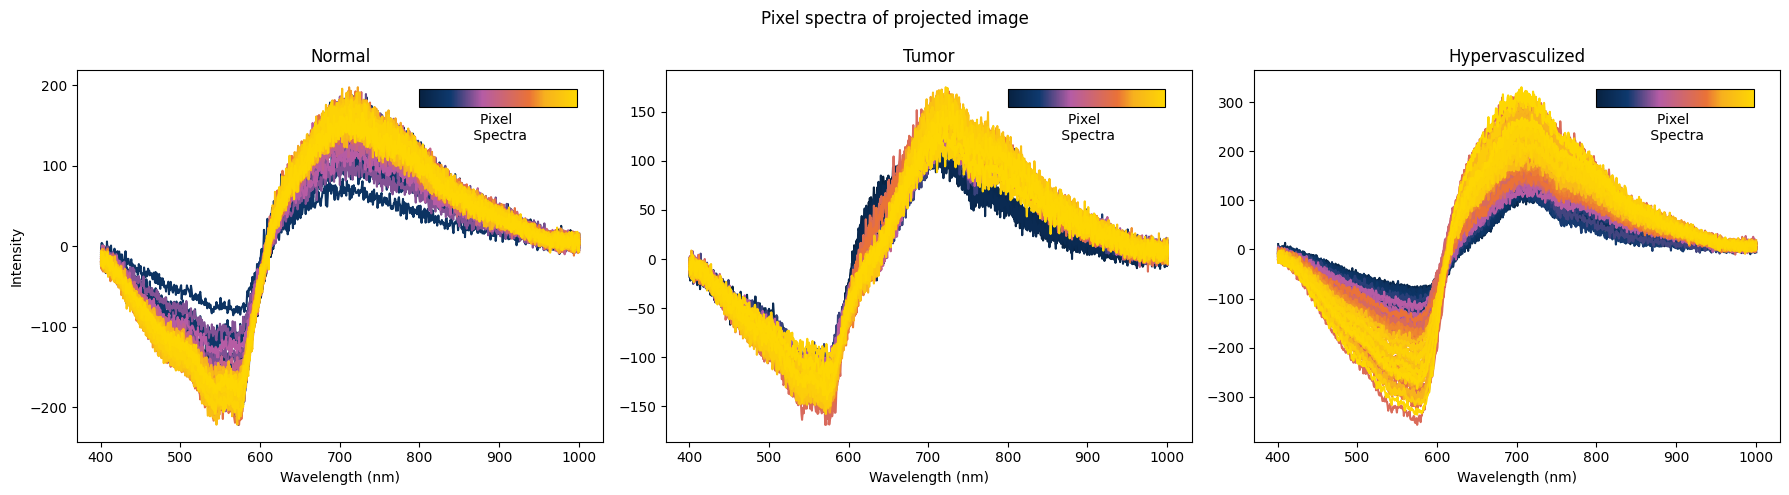

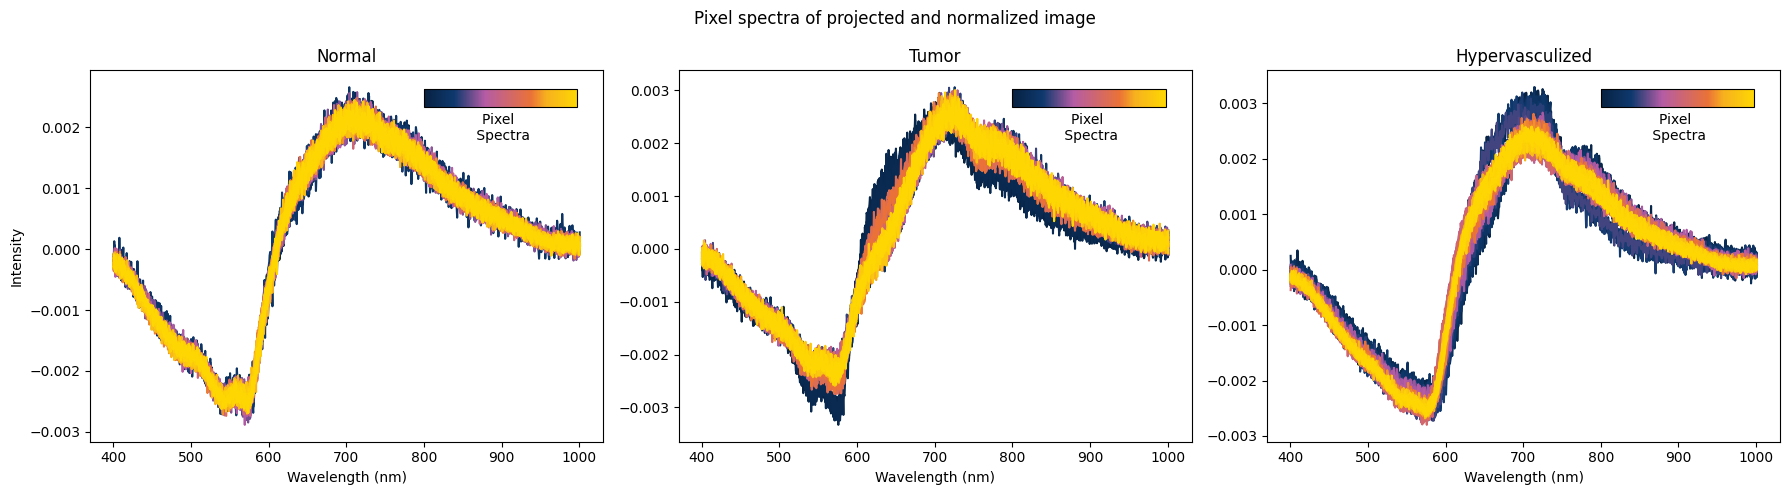

In [17]:
nspectra = 100

# plot raw spectra
fig, axs = plot_class_spectra(img_raw, gt_map, nspectr=nspectra, bands=band_centers)#, figsize=(5.68,2))
fig.suptitle('Pixel spectra of raw image')
axs[0].set_ylabel('Intensity')
plt.tight_layout()
# plt.savefig("../figures/raw_image_spectra_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# plot calibrated spectra
fig, axs = plot_class_spectra(img_calib, gt_map, nspectr=nspectra, bands=band_centers)#, figsize=(5.68,2))
fig.suptitle('Pixel spectra of calibrated image')
axs[0].set_ylabel('Intensity')
plt.tight_layout()
# plt.savefig("../figures/calib_image_spectra_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# plot calibrated spectra
fig, axs = plot_class_spectra(img_calib_norm, gt_map, nspectr=nspectra, bands=band_centers)#, figsize=(5.68,2))
fig.suptitle('Pixel spectra of calibrated and normalized image')
axs[0].set_ylabel('Intensity')
plt.tight_layout()
# plt.savefig("../figures/calib_norm_image_spectra_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# plot projected spectra
fig, axs = plot_class_spectra(R_E, gt_map, nspectr=nspectra, bands=band_centers)#, figsize=(5.68,2))
fig.suptitle('Pixel spectra of projected image')
axs[0].set_ylabel('Intensity')
plt.tight_layout()
# plt.savefig("../figures/proj_norm_image_spectra_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# plot projected and normalized spectra
fig, axs = plot_class_spectra(R_E_norm, gt_map, nspectr=nspectra, bands=band_centers)#, figsize=(5.68,2))
fig.suptitle('Pixel spectra of projected and normalized image')
axs[0].set_ylabel('Intensity')
plt.tight_layout()
# plt.savefig("../figures/proj_norm_image_spectra_helicoid_12-01.svg", format='svg', bbox_inches='tight')


Plot class-wise mean spectra and bands from image before and after preprocessing

Text(0.5, 0.98, 'Mean pixel spectra of projected and normalized image')

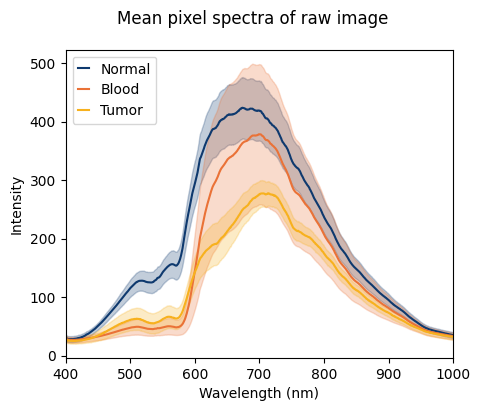

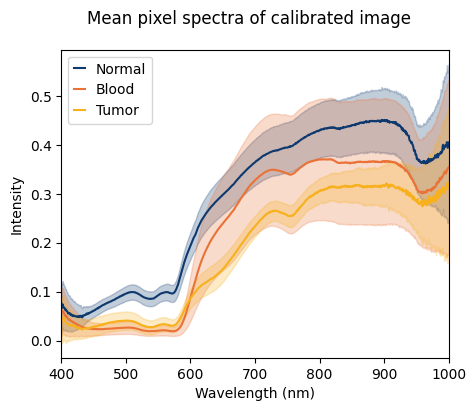

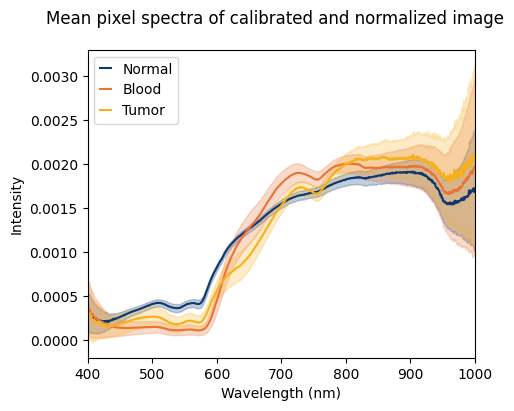

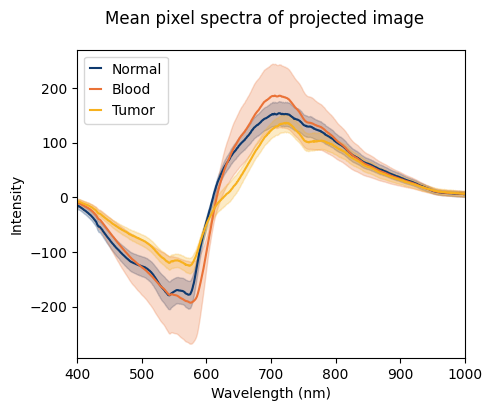

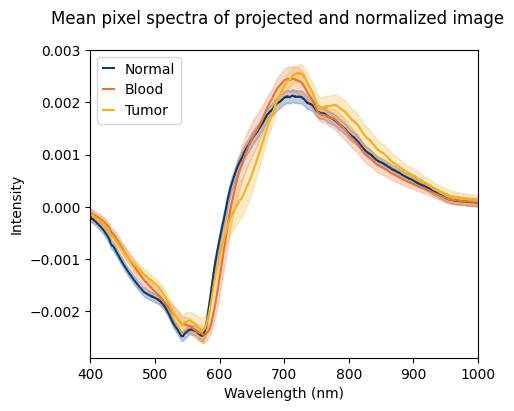

In [16]:
set_plotting_style("default")

# plot mean raw spectra
fig, ax = plot_class_dist(img, gt_map, band_centers, [1,3,2], class_labels, class_colors)#, figsize=(2.7,2), legend_loc='upper right')
fig.suptitle('Mean pixel spectra of raw image')
# plt.savefig("../figures/raw_image_dist_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# plot mean calibrated spectra
fig, ax = plot_class_dist(img_calib, gt_map, band_centers, [1,3,2], class_labels, class_colors)#, figsize=(2.7,2), legend_loc='upper left')
fig.suptitle('Mean pixel spectra of calibrated image')
# plt.savefig("../figures/calib_image_dist_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# plot mean calibrated and normalized spectra
fig, ax = plot_class_dist(img_calib_norm, gt_map, band_centers, [1,3,2], class_labels, class_colors)#, figsize=(2.7,2), legend_loc='upper left')
fig.suptitle('Mean pixel spectra of calibrated and normalized image')
# plt.savefig("../figures/calib_norm_image_dist_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# plot mean projected spectra
fig, ax = plot_class_dist(R_E, gt_map, band_centers, [1,3,2], class_labels, class_colors)#, figsize=(2.7,2), legend_loc='upper left')
fig.suptitle('Mean pixel spectra of projected image')
# plt.savefig("../figures/proj_image_dist_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# plot mean projected and normalized spectra
fig, ax = plot_class_dist(R_E_norm, gt_map, band_centers, [1,3,2], class_labels, class_colors)#, figsize=(2.7,2), legend_loc='upper left')
fig.suptitle('Mean pixel spectra of projected and normalized image')
# plt.savefig("../figures/proj_norm_image_dist_helicoid_12-01.svg", format='svg', bbox_inches='tight')



Plot examplary bands from image before and after preprocessing

Text(0.5, 0.98, 'Projected and normalized image for different bands')

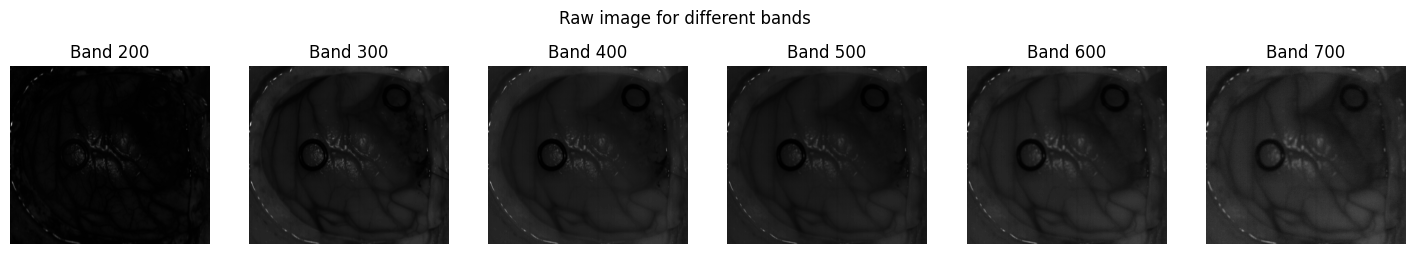

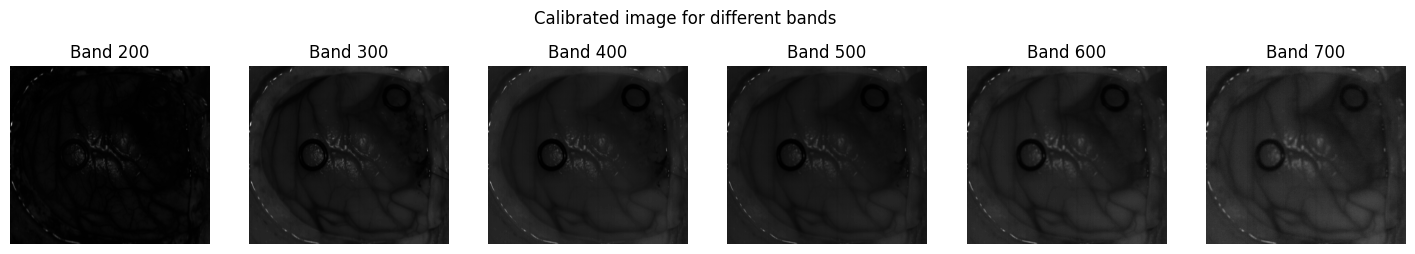

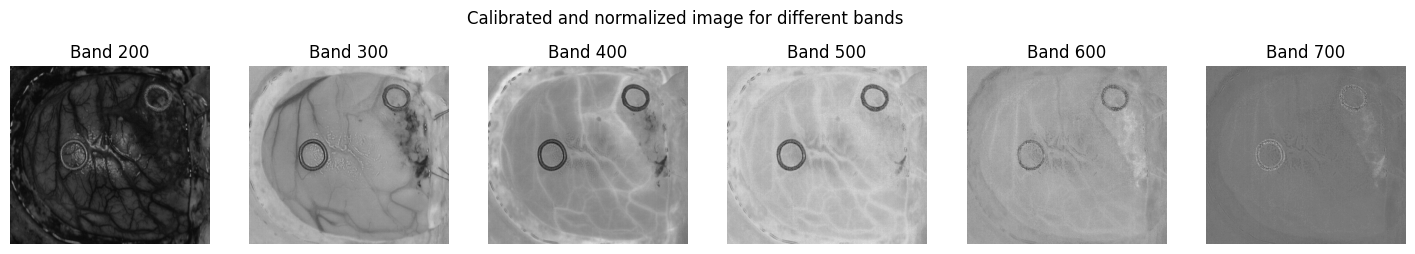

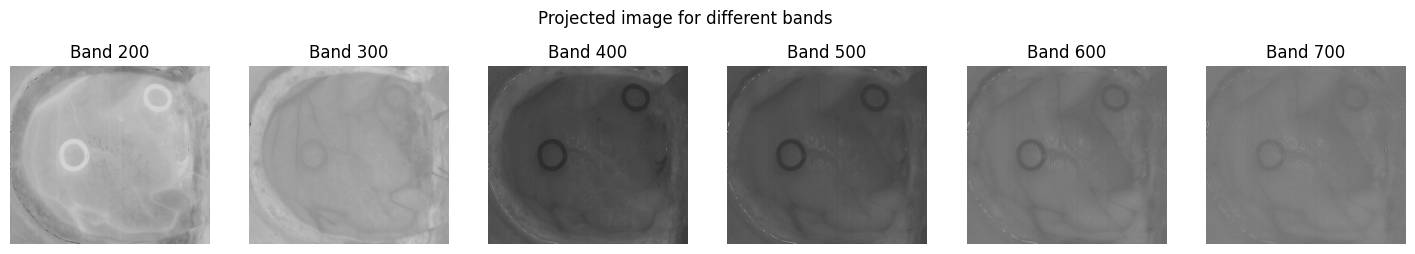

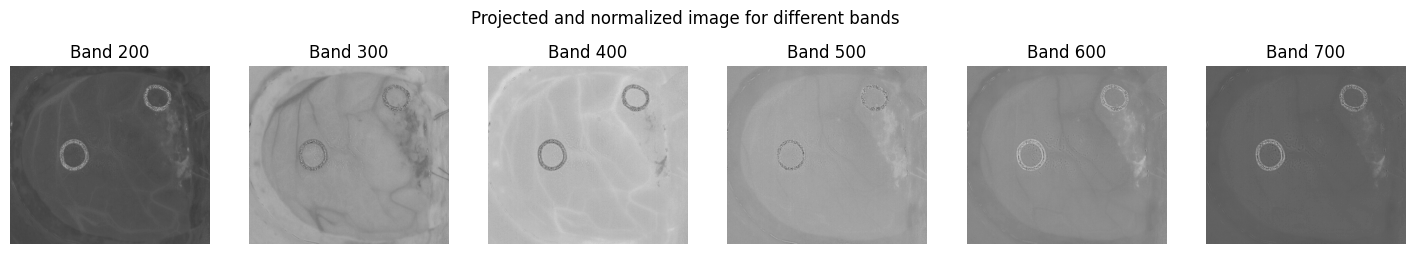

In [22]:
# plot raw image for different bands
fig, axs = plot_bands(img.asarray())#, figsize=(7.2,1))
fig.suptitle('Raw image for different bands')
plt.tight_layout()
# plt.savefig("../figures/raw_image_bands_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# plot calibrated image for different bands
fig, axs = plot_bands(img_calib)#, figsize=(7.2,1))
fig.suptitle('Calibrated image for different bands')
plt.tight_layout()
# plt.savefig("../figures/calib_image_bands_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# plot calibrated image for different bands
fig, axs = plot_bands(img_calib_norm)#, figsize=(7.2,1))
fig.suptitle('Calibrated and normalized image for different bands')
plt.tight_layout()
# plt.savefig("../figures/calib_norm_image_bands_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# plot projected image for different bands
fig, axs = plot_bands(R_E)#, figsize=(7.2,1))
fig.suptitle('Projected image for different bands')
plt.tight_layout()
# plt.savefig("../figures/proj_image_bands_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# plot projected and normalized image for different bands
fig, axs = plot_bands(R_E_norm)#, figsize=(7.2,1))
fig.suptitle('Projected and normalized image for different bands')
plt.tight_layout()
# plt.savefig("../figures/proj_image_bands_helicoid_12-01.svg", format='svg', bbox_inches='tight')


The problem with L1 normalization is that it amplifies pixels with small magntude leading them to be very noisy. This leads to low contrast in the normalized images due to few extreme pixels.

However, if we just focus on labeled pixels this should not be a proplem.

Alternatively, we could use a threshold to set pixeld with too small spectrum magnitude to 0

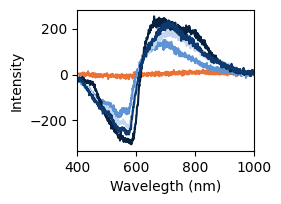

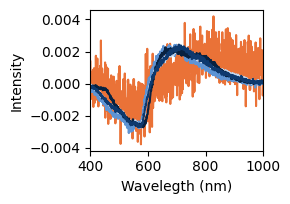

In [21]:
# plot spectra before and after normalization of 012-01

# np.random.seed(5)
# n = 10
# idxs = (np.random.randint(0, R_E.shape[0],n), np.random.randint(0, R_E.shape[1], n))

idxs = (np.array([73, 206, 189, 118, 400]), np.array([399, 158, 208, 7, 204])) # example pixel: (73,399)

color_list = [tum_red, tum_blue_light, tum_blue_light_2, tum_blue_dark, tum_blue_dark_2]

set_plotting_style("default")

fig, ax = plt.subplots(figsize=(2.54,2))
fig.tight_layout()
for x, y, color in zip(idxs[0], idxs[1], color_list):
    ax.plot(img.bands.centers, R_E[x,y,:], color=color)
ax.set_xlim([400, 1000])
ax.set_ylabel('Intensity')
ax.set_xlabel('Wavelegth (nm)')
# axs[0].set_title('Before normalization')
plt.savefig("../figures/projected_spectra_before_norm_helicoid_12-01.svg", format='svg', bbox_inches='tight')

R_E_norm = R_E/np.linalg.norm(R_E, axis=2, ord=1, keepdims=True)
fig, ax = plt.subplots(figsize=(2.5,2))
fig.tight_layout()
for x, y, color in zip(idxs[0], idxs[1], color_list):
    ax.plot(img.bands.centers, R_E_norm[x,y,:], color=color)
ax.set_xlim([400, 1000])
ax.set_ylabel('Intensity')
ax.set_xlabel('Wavelegth (nm)')
# ax.set_title('After normalization')
plt.savefig("../figures/projected_spectra_after_norm_helicoid_12-01.svg", format='svg', bbox_inches='tight')


